In [1]:
#supress warnings 

import warnings 
warnings.filterwarnings('ignore')

#basic libraries 
import numpy as np
import pandas as pd 

#for data visualization
import matplotlib.pyplot as mlt
#%matplotlib as inline 
import seaborn as sns 

#for jupyter notebook widgets 
import ipywidgets as widgets
from ipywidgets import interact 
from ipywidgets import interact_manual 

#for interactive shells 
from IPython.display import display 

#setting up the chart size and background 
mlt.rcParams['figure.figsize'] = (16, 8)
mlt.style.use('fivethirtyeight')

In [2]:
## Let's read the data 
df = pd.read_csv('movie_metadata.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

In [4]:
#Let's remove all unnecessary columns 
df=df.drop(['color', 
                      'director_facebook_likes', 
                      'actor_3_facebook_likes', 
                      'actor_1_facebook_likes', 
                      'cast_total_facebook_likes', 
                      'actor_2_facebook_likes',  
                      'facenumber_in_poster', 
                      'content_rating', 
                      'country', 
                      'movie_imdb_link', 
                      'aspect_ratio',
                      'plot_keywords',
                      ], axis = 1)

df.columns 


Index(['director_name', 'num_critic_for_reviews', 'duration', 'actor_2_name',
       'gross', 'genres', 'actor_1_name', 'movie_title', 'num_voted_users',
       'actor_3_name', 'num_user_for_reviews', 'language', 'budget',
       'title_year', 'imdb_score', 'movie_facebook_likes'],
      dtype='object')

# Missing Value Imputation 

In [5]:
#Let's display sum and percentage of missing values 

sum=df.isnull().sum()
total=df.isnull().count()
percent=(sum/total)*100
missing_data=pd.concat([sum,percent], axis=1, keys=("Sum", "Percentage"))
missing_data

#Let's display percentage of missing values by second method 
#p=round(100*(df.isnull().sum())/(len(df.index)),2)
#p

,Sum,Percentage
director_name,104,2.062265
num_critic_for_reviews,50,0.991473
duration,15,0.297442
actor_2_name,13,0.257783
gross,884,17.529248
genres,0,0.000000
actor_1_name,7,0.138806
movie_title,0,0.000000
num_voted_users,0,0.000000
actor_3_name,23,0.456078


In [6]:
# Since 'gross' and 'budget' columns have large number of NaN values, drop all the rows with NaNs at this column using the
# 'isnan' function of NumPy alongwith a negation '~'

df=df[~np.isnan(df['gross'])]
df=df[~np.isnan(df['budget'])]

df.isnull().sum()

director_name              0
num_critic_for_reviews     1
duration                   1
actor_2_name               5
gross                      0
genres                     0
actor_1_name               3
movie_title                0
num_voted_users            0
actor_3_name              10
num_user_for_reviews       0
language                   3
budget                     0
title_year                 0
imdb_score                 0
movie_facebook_likes       0
dtype: int64

In [8]:
#Let's remove the rows having sum of null value is greater than 2

df=df[df.isnull().sum(axis=1)<=2]
df.isnull().sum()

director_name             0
num_critic_for_reviews    1
duration                  1
actor_2_name              2
gross                     0
genres                    0
actor_1_name              0
movie_title               0
num_voted_users           0
actor_3_name              7
num_user_for_reviews      0
language                  3
budget                    0
title_year                0
imdb_score                0
movie_facebook_likes      0
dtype: int64

In [17]:
#let's start imputing missing values by statistical methods 

#mean for numerical column 
df['num_critic_for_reviews'].fillna(df['num_critic_for_reviews'].mean(), inplace=True)
df['duration'].fillna(df['duration'].mean(), inplace=True)

#mode for categorical column 
df['language'].fillna(df['language'].mode(), inplace=True)

#As we can't use statistical methods for Actors name, so will replace blank value by unknown actor 
df['actor_2_name'].fillna('Unknown Actor', inplace=True)
df['actor_3_name'].fillna('Unknown Actor', inplace=True)

#as we imputed all the missing values, let's seee 
df.isnull().sum().sum()

3

# Feature Engineering 

In [18]:
# Lets convert the gross and budget from $ to Million $ to make easily readable

df['gross'] = df['gross']/1000000
df['budget'] = df['budget']/1000000

#created profit column 
df['Profit'] = df['gross'] - df['budget']

#let's check the name top profitable movies
df[['Profit','movie_title']].sort_values(by='Profit', ascending=False).head(10)

,Profit,movie_title
0,523.505847,Avatar
29,502.177271,Jurassic World
26,458.672302,Titanic
3024,449.935665,Star Wars: Episode IV - A New Hope
3080,424.449459,E.T. the Extra-Terrestrial
794,403.279547,The Avengers
17,403.279547,The Avengers
509,377.783777,The Lion King
240,359.544677,Star Wars: Episode I - The Phantom Menace
66,348.316061,The Dark Knight


In [19]:
# The Duration of Movies is not varying a lot but we know that most of the users either like watching long movies or short 
# duration movies. we can categorize the movies in two part i.e., short and long.

# lets define a function for categorizing Duration of Movies
def duration(x):
    if x <= 120:
        return 'Short'
    else:
        return 'Long'
    
# lets apply this function on the duration column
df['duration'] = df['duration'].apply(duration)
df['duration'].value_counts()   

Short    2966
Long      922
Name: duration, dtype: int64

In [20]:
df['language'].value_counts()

English       3704
French          37
Spanish         26
Mandarin        15
German          13
Japanese        12
Hindi           10
Cantonese        8
Italian          7
Portuguese       5
Korean           5
Norwegian        4
Thai             3
Dutch            3
Danish           3
Hebrew           3
Persian          3
Aboriginal       2
Dari             2
Indonesian       2
Arabic           1
Vietnamese       1
Kazakh           1
Aramaic          1
None             1
Filipino         1
Dzongkha         1
Maya             1
Russian          1
Hungarian        1
Swedish          1
Icelandic        1
Bosnian          1
Romanian         1
Czech            1
Zulu             1
Mongolian        1
Telugu           1
Name: language, dtype: int64

In [21]:
# Looking at the above output we can easily observe that out of 3,500 movies only 150 movies are of other languages

# so it is better to keep only two languages that is English and Foreign

def lang(x):
    if x == 'English':
        return 'English'
    else:
        return 'Foreign'
# lets apply the function on the language column
df['language']=df['language'].apply(lang)
df['language'].value_counts()


English    3704
Foreign     184
Name: language, dtype: int64

In [22]:
# lets also check the values in the Genres Column

df['genres'].value_counts()

Drama                                    154
Comedy|Drama|Romance                     151
Comedy|Drama                             148
Comedy                                   147
Comedy|Romance                           136
                                        ... 
Action|Crime|Mystery|Sci-Fi|Thriller       1
Adventure|Sci-Fi                           1
Adventure|Biography|Documentary|Drama      1
Comedy|Mystery|Romance                     1
Adventure|Comedy|Family|Musical            1
Name: genres, Length: 762, dtype: int64

In [23]:
df['genres'].str.split('|')[0]

['Action', 'Adventure', 'Fantasy', 'Sci-Fi']

In [24]:
# we can see from the above output that most of the movies are having a lot of genres
# also, a movie can have so many genres so lets keep four genres

df['Moviegenres'] = df['genres'].str.split('|')
df['Genre1'] = df['Moviegenres'].apply(lambda x: x[0])

# Some of the movies have only one genre. In such cases, assign the same genre to 'genre_2' as well
df['Genre2'] = df['Moviegenres'].apply(lambda x: x[1] if len(x) > 1 else x[0])
df['Genre3'] = df['Moviegenres'].apply(lambda x: x[2] if len(x) > 2 else x[0])
df['Genre4'] = df['Moviegenres'].apply(lambda x: x[3] if len(x) > 3 else x[0])

# lets check the head of the  data
df[['genres','Genre1','Genre2','Genre3','Genre4']].head(5)

,genres,Genre1,Genre2,Genre3,Genre4
0,Action|Adventure|Fantasy|Sci-Fi,Action,Adventure,Fantasy,Sci-Fi
1,Action|Adventure|Fantasy,Action,Adventure,Fantasy,Action
2,Action|Adventure|Thriller,Action,Adventure,Thriller,Action
3,Action|Thriller,Action,Thriller,Action,Action
5,Action|Adventure|Sci-Fi,Action,Adventure,Sci-Fi,Action


# Data Visualization

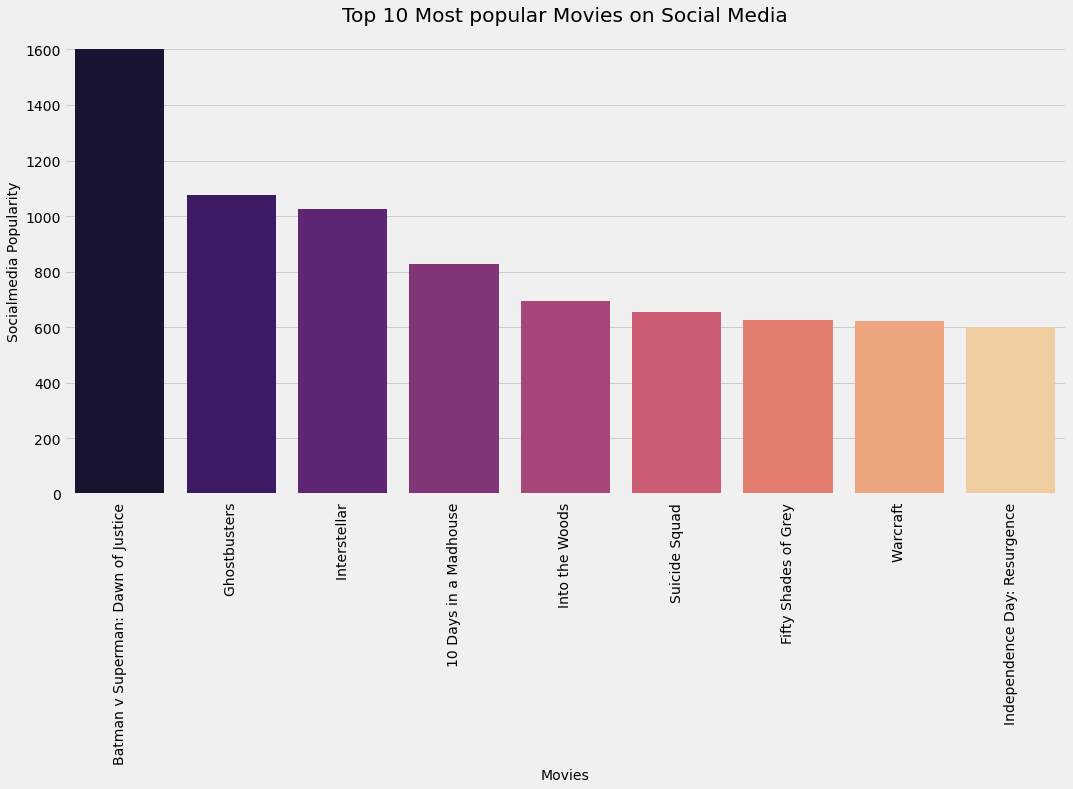

In [26]:
# lets also calculate the Social Media Popularity of a Movie 

# to calculate popularity of a movie, we can aggregate No. of voted users, No. of Users for Reviews, and Facebook Likes.
df['socialmedia']=(df['num_user_for_reviews']/df['num_voted_users'])*df['movie_facebook_likes']

# lets also check the Top 10 Most Popular Movies on Social Media
x=df[['movie_title','socialmedia']].sort_values(by='socialmedia',ascending=False).head(10).reset_index()
x

#plot
sns.barplot(x['movie_title'], x['socialmedia'], palette='magma')
mlt.title('Top 10 Most popular Movies on Social Media')
mlt.xlabel('Movies', fontsize=14)
mlt.ylabel('Socialmedia Popularity',fontsize=14)
mlt.xticks(rotation = 90, fontsize = 14)
mlt.show()

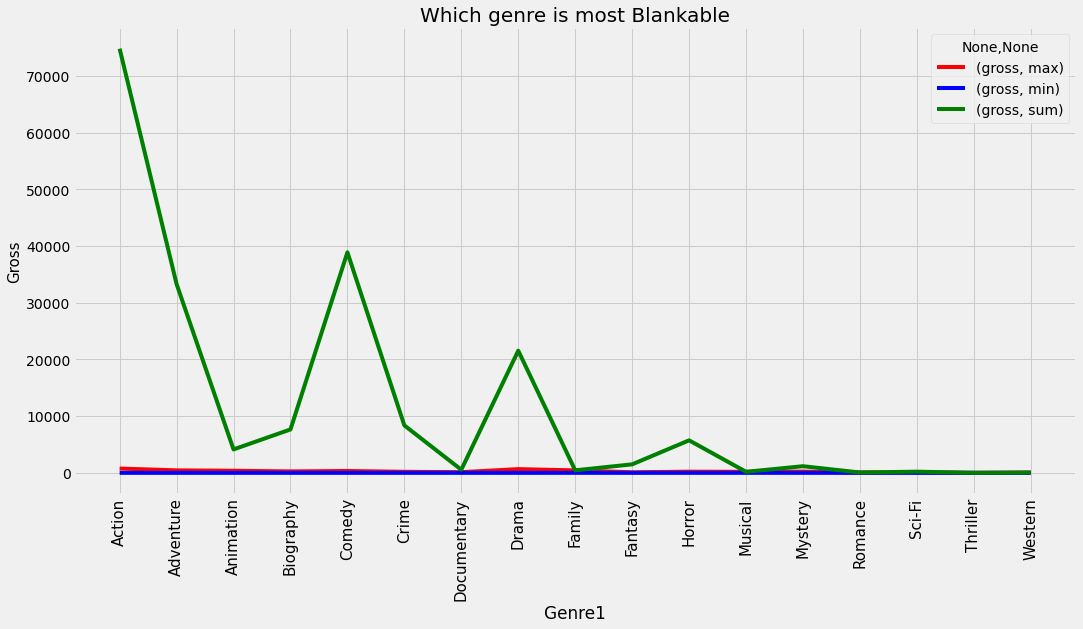

In [27]:
#Let's group Genre and then calculate max,min and sum of each genre for movies 
display(df[['Genre1','gross']].groupby(['Genre1']).agg(['max','min','sum']).style.background_gradient(cmap = 'Wistia'))

#plot
df[['Genre1','gross']].groupby(['Genre1']).agg(['max','min','sum']).plot(kind = 'line', color = ['Red','Blue','Green'])
mlt.title('Which genre is most Blankable', fontsize=20)
mlt.xticks(np.arange(17), ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'Western'], rotation=90, fontsize=15)
mlt.ylabel('Gross', fontsize=15)
mlt.show()


### observation 
* Action and Drama has the highest Gross 
* Family and Musical has the Highest Gross, Average Gross is much impressive 
* Visualization also shows that Action, and Drama has very High Banking Capability.

In [29]:
print("The most Profitable Movie from each Genre")
display(df.loc[df.groupby(['Genre1'])['Profit'].idxmax()][['movie_title',
                                                           'Genre1', 'gross']].style.background_gradient(cmap = 'copper'))

The most Profitable Movie from each Genre


,movie_title,Genre1,gross
0,Avatar,Action,760.505847
509,The Lion King,Adventure,422.783777
521,Despicable Me 2,Animation,368.049635
1403,The Blind Side,Biography,255.950375
836,Forrest Gump,Comedy,329.691196
3466,The Godfather,Crime,134.821952
3583,Fahrenheit 9/11,Documentary,119.078393
26,Titanic,Drama,658.672302
3080,E.T. the Extra-Terrestrial,Family,434.949459
2485,The Others,Fantasy,96.471845


### observation
* The top Action Movie 'Avatar' has highest Gross
* The top Adventure Movie is 'The Lion King'
* The top Drama movie is Titanic 

Movies Profitable Years


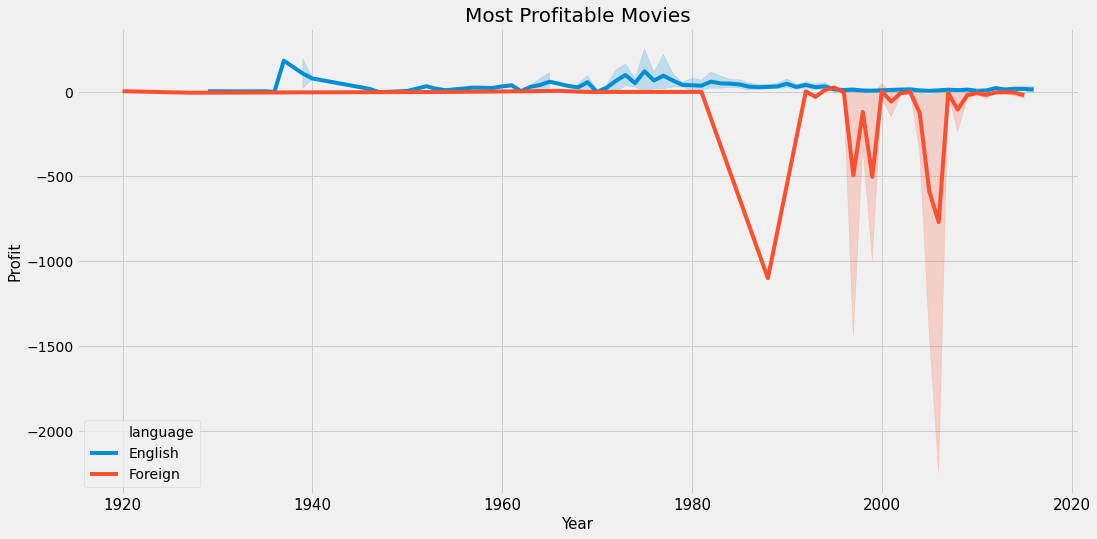

In [31]:
# lets convert year into integer
df['title_year']=df['title_year'].astype('int')

#We have to group the data by title year , language and aggregate the 'sum of Profit' made in each year
#as we want to know about the years in which Box office made the highest Profit so we have to use 'Sort value' fn and specify
#ascending = False so that we get output as Top Years 

print("Movies Profitable Years")
display(df[['language','title_year',
                    'Profit']].groupby(['language','title_year']).agg('sum').sort_values(by='Profit', 
                    ascending=False).head(10).style.background_gradient(cmap = 'Greens'))

#let's plot 
sns.lineplot(df['title_year'], df['Profit'], hue=df['language'])
mlt.title('Most Profitable Movies',fontsize=20)
mlt.xticks(fontsize=15)
mlt.xlabel('Year', fontsize=15)
mlt.ylabel('Profit', fontsize=15)
mlt.show()

In [32]:
print('Most movies with Huge Losses')
display(df[['movie_title','language','Profit']][df['Profit']<-2000].style.background_gradient(cmap = 'Reds'))

Most movies with Huge Losses


,movie_title,language,Profit
2323,Princess Mononoke,Foreign,-2397.701809
2334,Steamboy,Foreign,-2127.109510
2988,The Host,Foreign,-12213.298588
3005,Fateless,Foreign,-2499.804112
3859,Lady Vengeance,Foreign,-4199.788333


,movie_title,duration,gross,Profit
0,Avatar,Long,760.505847,523.505847
29,Jurassic World,Long,652.177271,502.177271
26,Titanic,Long,658.672302,458.672302
3024,Star Wars: Episode IV - A New Hope,Long,460.935665,449.935665
17,The Avengers,Long,623.279547,403.279547


,movie_title,duration,gross,Profit
3080,E.T. the Extra-Terrestrial,Short,434.949459,424.449459
509,The Lion King,Short,422.783777,377.783777
812,Deadpool,Short,363.024263,305.024263
521,Despicable Me 2,Short,368.049635,292.049635
338,Finding Nemo,Short,380.838870,286.838870


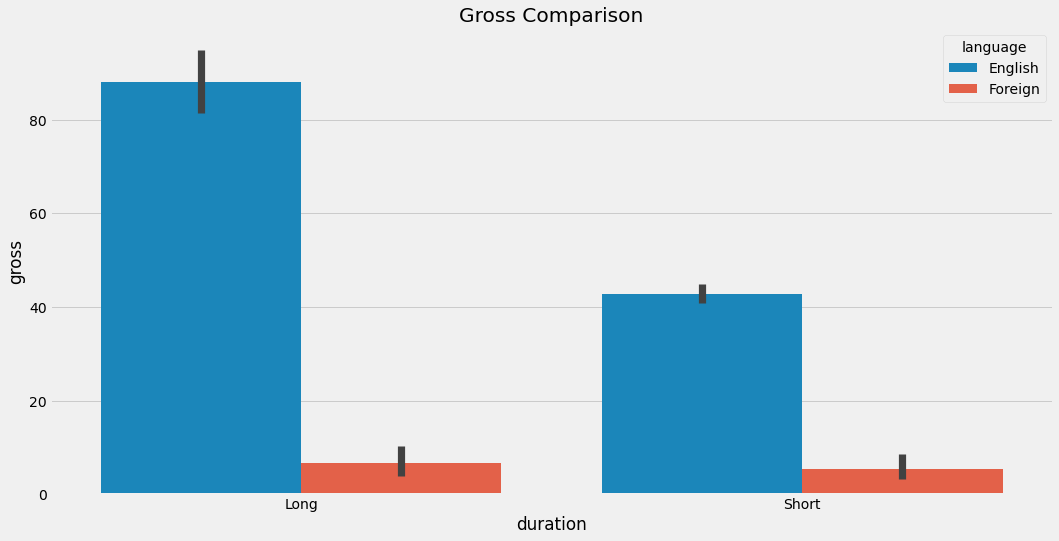

In [33]:
#Gross comparison of long and Short movies 
display(df[['movie_title','duration','gross','Profit']][df['duration']=='Long'].sort_values(by='Profit',
                                                        ascending=False).head(5).style.background_gradient(cmap = 'spring'))

display(df[['movie_title','duration','gross','Profit']][df['duration']=='Short'].sort_values(by='Profit',
                                                        ascending=False).head(5).style.background_gradient(cmap = 'spring'))

sns.barplot(df['duration'],df['gross'], hue=df['language'])
mlt.title('Gross Comparison')
mlt.show()

### Observation from table 
* there is a huge difference in Gross of Short and Long duration movies
* Avatar-The Long duration movie made a Gross around 760 million where E.T. the extra tresetial - The short duration movie made
* a Gross around 434 million which is small 
* The movies with longer durartion have high Gross or highest Banker capability

#### observation from Chart 
* Blue color depicts English Language movies, Red color depicts Foreign language movies
* English Long durartion movies have high Gross as compared to English Short movies 
* There is Neglegible difference in Long and Short Foreign movies 
* This will help you to understand the Association between each other  

In [35]:
#let's calculate imdb score of Long and Short duration movies 
print('Average imdb score for Long duration Movies {0:0.2f}'.format(df[df['duration']=='Long']['imdb_score'].mean()))
print('Average imdb score for Dhort duration Movies {0:0.2f}'.format(df[df['duration']=='Short']['imdb_score'].mean()))
                                                                      
print('Highest Rated Long Duration Movie')
display(df[['movie_title','imdb_score']][df['duration']=='Long'].sort_values(by='imdb_score', ascending=False).head(1))

print('Highest Rated Short Duration Movie')
display(df[['movie_title','imdb_score']][df['duration']=='Short'].sort_values(by='imdb_score', ascending=False).head(1))

Average imdb score for Long duration Movies 7.06
Average imdb score for Dhort duration Movies 6.28
Highest Rated Long Duration Movie


,movie_title,imdb_score
1937,The Shawshank Redemption,9.3


Highest Rated Short Duration Movie


,movie_title,imdb_score
3175,American History X,8.6


# Here we are finding Association between Imdb score and Duration of the movies 
#### Duration is one of the Key factors that users use for deciding which Movie to watch from an OTT Platform such as Netflix, Hulu, Hotstar, and Amazon Prime etc 
#### Duration is an Important Factor driving Gross of a Movie as IMDB Rating and Gross of a Movie are Directly Proportional in Nature
#### Highest Rated Long duration movie is 9.3
#### Highest Rated Short duration movie is 8.6

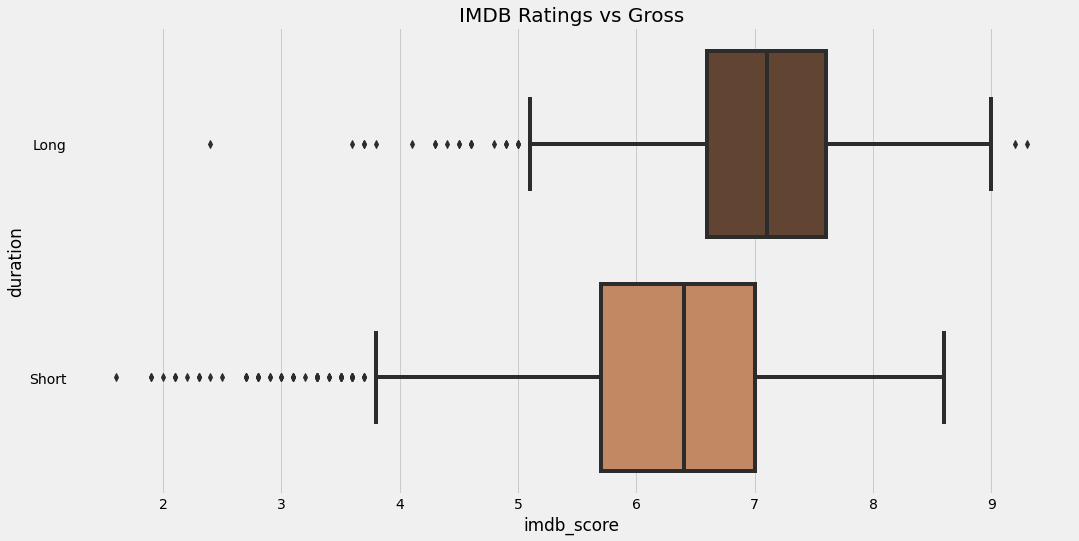

In [37]:
#Let's plot Short and Long duration movies 
sns.boxplot(df['imdb_score'], df['duration'], palette='copper')
mlt.title('IMDB Ratings vs Gross', fontsize=20)
mlt.show()

## Here Long duration movies has better IMDB Score distribution in comparison to Short duration movie. So we can conclude Long duartion movies have more impact on Box office

In [38]:
#let's find out the maximum and minimum Gross, Time period, Avg Imdb .... of specific actor    

def actors(x):
    a = df[df['actor_1_name'] == x]
    b = df[df['actor_2_name'] == x]
    c = df[df['actor_1_name'] == x]
    x = a.append(b)
    y = x.append(c)
    
    y = y[['movie_title',
       'budget', 'gross','title_year','genres','language','imdb_score']]
    return y
    

In [39]:
actors('Meryl Streep')

,movie_title,budget,gross,title_year,genres,language,imdb_score
410,It's Complicated,85.0,112.703470,2009,Comedy|Drama|Romance,English,6.6
1106,The River Wild,45.0,46.815748,1994,Action|Adventure|Crime|Thriller,English,6.3
1204,Julie & Julia,40.0,94.125426,2009,Biography|Drama|Romance,English,7.0
1408,The Devil Wears Prada,35.0,124.732962,2006,Comedy|Drama|Romance,English,6.8
1483,Lions for Lambs,35.0,14.998070,2007,Drama|Thriller|War,English,6.2
1575,Out of Africa,31.0,87.100000,1985,Biography|Drama|Romance,English,7.2
1618,Hope Springs,30.0,63.536011,2012,Comedy|Drama|Romance,English,6.3
1674,One True Thing,30.0,23.209440,1998,Drama,English,7.0
1925,The Hours,25.0,41.597830,2002,Drama|Romance,English,7.6
2781,The Iron Lady,13.0,29.959436,2011,Biography|Drama|History,English,6.4


In [40]:
#result is huge which is not easy to analyse so let's create another function which calulate summary of an actor i.e. 
#max and min gross, TimePeriod, Avg Imdb score and so no 

def actors_reports(x):
    a = df[df['actor_1_name'] == x]
    b = df[df['actor_2_name'] == x]
    c = df[df['actor_3_name'] == x]
    x = a.append(b)
    y = x.append(c)
    print('Time', y['title_year'].max(), y['title_year'].min())
    print('Max Gross {0:0.2f} Millions'.format(y['gross'].max()))
    print('Min Gross {0:0.2f} Millions'.format(y['gross'].min()))
    print('Avg Gross {0:0.2f} Millions'.format(y['gross'].mean()))
    print('Number of 100 Million Movies', y[y['gross']>100].shape[0])
    print('Average IMDB Score : {0:0.2f}'.format(y['imdb_score'].mean()))
    print('Most common Genres', y['Genre1'].value_counts())
    
actors_reports('Meryl Streep')
    

Time 2014 1985
Max Gross 143.70 Millions
Min Gross 9.66 Millions
Avg Gross 55.23 Millions
Number of 100 Million Movies 4
Average IMDB Score : 6.81
Most common Genres Drama        9
Comedy       7
Biography    3
Adventure    3
Action       1
Name: Genre1, dtype: int64


In [41]:
### Observations of Career of Meryl Streep
### Her career is 30 years old(1985 - 2014)
### Her Maximum gross was 143.7 million
### Her average IMDB score is 6.81
### She has done 4 movies which Crossed more than 100 million mark in world wide Market 

In [42]:
#Let's compare Brad Pitt, Leonardo Caprio and Tom Cruise

def critically_acclaimed_actors(x):
    a = df[df['actor_1_name'] == x]
    b = df[df['actor_2_name'] == x]
    c = df[df['actor_3_name'] == x]
    x = a.append(b)
    y = x.append(c)
    return y['num_critic_for_reviews'].sum().astype('int')

print("Number of Critics Reviews for Brad Pitt")
display(critically_acclaimed_actors('Brad Pitt'))

print("Number of Critics Reviews for 'Leonardo DiCaprio'")
display(critically_acclaimed_actors('Leonardo DiCaprio'))

print("Number of Critics Reviews for Tom Cruise")
display(critically_acclaimed_actors('Tom Cruise'))

Number of Critics Reviews for Brad Pitt


7965

Number of Critics Reviews for 'Leonardo DiCaprio'


7014

Number of Critics Reviews for Tom Cruise


6740

In [43]:
pd.set_option('max_rows', 3000)

#fetching movies according to their Imdb scores 

@interact
def show_movies_more_than(column='imdb_score', score=9.0):
    x = df.loc[df[column] > score][[ 'title_year','movie_title',
                                       'director_name',
                                       'actor_1_name',
                                       'actor_2_name',
                                       'actor_3_name',
                                       'Profit',
                                       'imdb_score',
                                    ]]
    
 #   x = x.sort_values(by = 'imdb_score', ascending = False)
  #  x = x.drop_duplicates(keep = 'first')
    return x

interactive(children=(Text(value='imdb_score', description='column'), FloatSlider(value=9.0, description='scor…

In [44]:
pd.set_option('max_rows', 30000)

@interact
def show_articles_more_than(column=['budget','gross'], x = 10000):
    x = df.loc[df[column] > x][['movie_title','duration','gross','Profit','imdb_score']]
    return x

interactive(children=(Dropdown(description='column', options=('budget', 'gross'), value='budget'), IntSlider(v…

# Recommendation Movies based on Actors

In [45]:
#as we have 3 actors in the dataset so we need to check for each column means Priyanka chopra was first lead in 'Fashion', 
#second lead in 'Krish' and the third lead in 'Bajirao Mastani'

def recommendation_movies_on_actors(x):
    a = df[['movie_title','imdb_score']][df['actor_1_name'] == x]
    b = df[['movie_title','imdb_score']][df['actor_2_name'] == x]
    c = df[['movie_title','imdb_score']][df['actor_3_name'] == x]   
    x = a.append(b)  #After collecting data from all three columns we will join them together for secific actor  
    y = x.append(c)
    return y

recommendation_movies_on_actors('Tom Cruise').sort_values(by='imdb_score', ascending=False)

,movie_title,imdb_score
1868,Rain Man,8.0
75,Edge of Tomorrow,7.9
284,Minority Report,7.7
158,The Last Samurai,7.7
736,Collateral,7.6
1524,A Few Good Men,7.6
940,Interview with the Vampire: The Vampire Chroni...,7.6
155,Mission: Impossible - Ghost Protocol,7.4
135,Mission: Impossible - Rogue Nation,7.4
671,Eyes Wide Shut,7.3


# Recommendation Similar Genres 
####  we used to filter movies according to Genres so that we can recommend more and more movies to the user according to their interest for better user experience


In [46]:
#Use Transactional Encoder so that we can get the Pivot of all the Movie Genres.
from mlxtend.preprocessing import TransactionEncoder

x = df['genres'].str.split('|')
te = TransactionEncoder()
x = te.fit_transform(x)
x = pd.DataFrame(x, columns=te.columns_)

x.head()

# Output :- all 26 Genres are separated in diff columns whether you can either see True or False. For True, 
#movies belongs to Genres else not  

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,True,True,False,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
1,True,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [47]:
#typecast these boolean values into integer values so that we can calculate correlation between different genres 
genres = x.astype('int')
genres.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [48]:
# lets insert movies title in the first column from Excel data, so that we can better understand the data
# now we understand which movie belong to which genres

genres.insert(0, 'movies_title', df['movie_title'])
genres.head()


,movies_title,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Avatar,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,Pirates of the Caribbean: At World's End,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Spectre,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,The Dark Knight Rises,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,NaN,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [50]:
#Let's set these movies title as index of the data, to perfrom correlation we need all values to be numerical
genres = genres.set_index('movies_title')

genres.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
movies_title,,,,,,,,,,,,,,,,,,,,,
Avatar,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
Pirates of the Caribbean: At World's End,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Spectre,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
The Dark Knight Rises,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
NaN,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [51]:
# making a recommendation engine for getting similar genres by applying correlation function so that we can get most simililar 
# genres to each other

def recommendation_genres(gen):
    gen = genres[gen]
    similar_genres = genres.corrwith(gen)
    similar_genres = similar_genres.sort_values(ascending=False)
    similar_genres = similar_genres.iloc[1:]
    return similar_genres.head(3)

In [52]:
#test the function with Action Genre
#Adventure, Thriller and SciFi are the most similar genres to Action
recommendation_genres('Action')

Adventure    0.322249
Thriller     0.299882
Sci-Fi       0.296284
dtype: float64

# Recommending similar Movies

In [53]:
#Let's recommend movies too using the same logic  
# lets make a sparse matrix to recommend the movies by transposing the Pivot table that we created to recommend similar genres

x = genres.transpose()
x.head()

movies_title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,NaN,John Carter,Spider-Man 3,Tangled,Avengers: Age of Ultron,Harry Potter and the Half-Blood Prince,...,NaN,Pan,NaN,NaN,NaN,Night Watch,The Crying Game,Porky's,Survival of the Dead,NaN
Action,1,1,1,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
Adventure,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Animation,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Biography,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Comedy,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [54]:
#let's apply correlation function to get the simpliarity between movies
# making a recommendation engine for getting similar movies

def recommendation_movie(movie):    
    movie = x[movie+'\xa0']
    similar_movies = x.corrwith(movie)
    similar_movies = similar_movies.sort_values(ascending=False)
    similar_movies = similar_movies.iloc[1:]
    return similar_movies.head(20)

In [55]:
# lets test on some results
recommendation_movie('The Expendables')

movies_title
All Is Lost                                       1.0
Bram Stoker's Dracula                             1.0
The Corruptor                                     1.0
Star Trek IV: The Voyage Home                     1.0
House of Flying Daggers                           1.0
Cadillac Records                                  1.0
In the Name of the King: A Dungeon Siege Tale     1.0
Green Room                                        1.0
For Your Consideration                            1.0
Flawless                                          1.0
Kill the Messenger                                1.0
Last Orders                                       1.0
NaN                                               1.0
My Name Is Khan                                   1.0
Rushmore                                          1.0
Dawn of the Dead                                  1.0
Georgia Rule                                      1.0
NaN                                               1.0
NaN            